In [4]:
import numpy as np
import pandas as pd 
import os

In [5]:
!pip install -U torchvision # We need a new versino of torchvision for this project

     |████████████████████████████████| 24.2 MB 7.9 MB/s            
     |████████████████████████████████| 887.5 MB 6.6 kB/s              
     |████████████████████████████████| 317.1 MB 25 kB/s              
     |████████████████████████████████| 21.0 MB 60.6 MB/s            
     |████████████████████████████████| 557.1 MB 4.6 kB/s              
     |████████████████████████████████| 849 kB 55.7 MB/s            
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.13.1 which is in

In [6]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [8]:
print(torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


In [9]:
!pip install pycocotools
from pycocotools.coco import COCO

     |████████████████████████████████| 403 kB 7.8 MB/s            


In [10]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [17]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [11]:
class TankDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) 
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [12]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined/"

In [13]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [14]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [18]:
train_dataset = TankDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


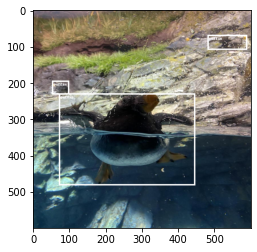

In [19]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [20]:
len(train_dataset)

447

In [21]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [24]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [25]:
device = torch.device("cuda") # use GPU to train

In [26]:
model = model.to(device)

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [28]:
import sys

In [29]:
num_epochs = 10

for epoch in range(num_epochs):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Move images and targets to the specified device
        images = [image.to(device) for image in images]
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass: compute losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        # Store losses for logging
        all_losses.append(loss_value)
        all_losses_dict.append({k: v.item() for k, v in loss_dict.items()})
        
        # Check for infinite loss
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Log the average losses for the epoch
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print(f"Epoch {epoch + 1}, lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
          f"loss_box: {all_losses_dict['loss_box_reg'].mean():.6f}, "
          f"loss_rpn_box: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
          f"loss_object: {all_losses_dict['loss_objectness'].mean():.6f}")

Epoch 1/10: 100%|██████████| 112/112 [00:23<00:00,  4.85it/s]


Epoch 1, lr: 0.010000, loss: 0.978631, loss_classifier: 0.459346, loss_box: 0.391186, loss_rpn_box: 0.033445, loss_object: 0.094654


Epoch 2/10: 100%|██████████| 112/112 [00:16<00:00,  6.89it/s]


Epoch 2, lr: 0.010000, loss: 0.787965, loss_classifier: 0.355611, loss_box: 0.343116, loss_rpn_box: 0.028713, loss_object: 0.060525


Epoch 3/10: 100%|██████████| 112/112 [00:16<00:00,  6.98it/s]


Epoch 3, lr: 0.010000, loss: 0.718657, loss_classifier: 0.302708, loss_box: 0.340035, loss_rpn_box: 0.026626, loss_object: 0.049287


Epoch 4/10: 100%|██████████| 112/112 [00:15<00:00,  7.17it/s]


Epoch 4, lr: 0.010000, loss: 0.693801, loss_classifier: 0.279386, loss_box: 0.349738, loss_rpn_box: 0.024841, loss_object: 0.039837


Epoch 5/10: 100%|██████████| 112/112 [00:15<00:00,  7.19it/s]


Epoch 5, lr: 0.010000, loss: 0.661930, loss_classifier: 0.259868, loss_box: 0.338618, loss_rpn_box: 0.024265, loss_object: 0.039179


Epoch 6/10: 100%|██████████| 112/112 [00:15<00:00,  7.31it/s]


Epoch 6, lr: 0.010000, loss: 0.653197, loss_classifier: 0.250934, loss_box: 0.345011, loss_rpn_box: 0.022991, loss_object: 0.034260


Epoch 7/10: 100%|██████████| 112/112 [00:15<00:00,  7.33it/s]


Epoch 7, lr: 0.010000, loss: 0.645229, loss_classifier: 0.248054, loss_box: 0.344753, loss_rpn_box: 0.022772, loss_object: 0.029650


Epoch 8/10: 100%|██████████| 112/112 [00:14<00:00,  7.49it/s]


Epoch 8, lr: 0.010000, loss: 0.631773, loss_classifier: 0.232073, loss_box: 0.348628, loss_rpn_box: 0.021518, loss_object: 0.029554


Epoch 9/10: 100%|██████████| 112/112 [00:15<00:00,  7.40it/s]


Epoch 9, lr: 0.010000, loss: 0.635488, loss_classifier: 0.233828, loss_box: 0.353376, loss_rpn_box: 0.020541, loss_object: 0.027745


Epoch 10/10: 100%|██████████| 112/112 [00:14<00:00,  7.55it/s]

Epoch 10, lr: 0.010000, loss: 0.651597, loss_classifier: 0.238531, loss_box: 0.368618, loss_rpn_box: 0.020434, loss_object: 0.024014


In [30]:
model.eval()
torch.cuda.empty_cache()

In [32]:
test_dataset = TankDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [51]:
img, _ = test_dataset[7]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

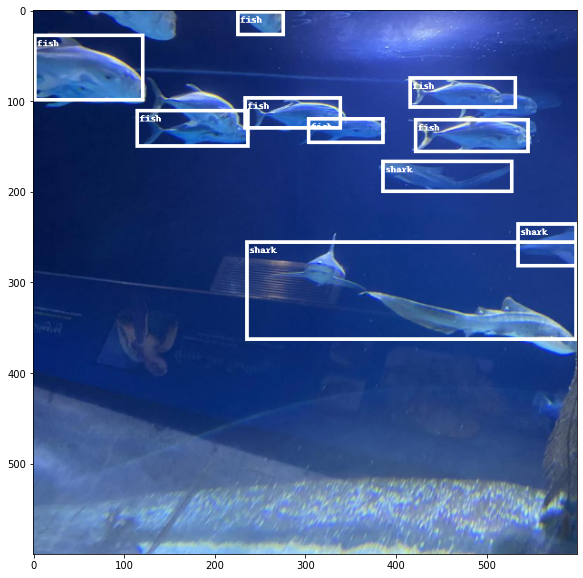

In [52]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))